In [514]:
import GPy  # see http://sheffieldml.github.io/GPy/ for install instructions
import numpy as np
import numpy.random as rng # random number generator
import matplotlib.pyplot as plt
from scipy.stats import norm as gaussian # useful for the Gaussian cdf.

In [515]:
noise = 0.1
# Noisy training data
def actual_surface(Xtrain,noise):
    evaluations = np.sin(Xtrain) + noise * np.random.randn(*Xtrain.shape)
#       evaluations = np.sin(Xtrain) + noise 
#     evaluations = Xtrain + noise * np.random.randn(*Xtrain.shape)
    return(evaluations)

# all the points we want to plot predictions at
X = np.arange(-5, 5, 0.2).reshape(-1, 1)

# Some initial measurements at a few points
X_train = 10*rng.random(4).reshape(-1,1) - 5
Y_train = actual_surface(X_train,noise)

# Make a nice plot
def plot_gp(mu, cov, X, X_train=None, Y_train=None, samples=[]):
# def plot_gp(mu, cov, X, X_train=None, samples=[]):
    X = X.ravel()
    mu = mu.ravel()
    uncertainty = 1.96 * np.sqrt(np.diag(cov))
    
    plt.fill_between(X, mu + uncertainty, mu - uncertainty, alpha=0.1)
    plt.plot(X, mu, label='Mean')
    for i, sample in enumerate(samples):
        plt.plot(X, sample, lw=1, ls='--', label=f'Sample {i+1}')
    if X_train is not None:
        plt.plot(X_train, Y_train, 'rx')
#         plt.plot(X_train, 'rx')        
    plt.legend()
    return(plt.gca())

# First, simple GP regression

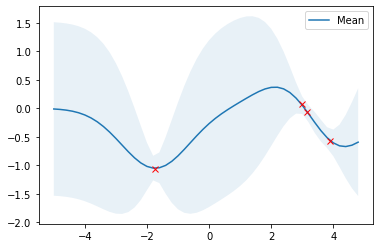

In [516]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import ConstantKernel, RBF,ExpSineSquared,RationalQuadratic

# 
# rbf =  ConstantKernel(1.0) *ExpSineSquared(length_scale=1.0)


rbf = ConstantKernel(1.0) * RBF(length_scale=1.0)
gpr = GaussianProcessRegressor(kernel=rbf, alpha=noise**2)

# Reuse training data from previous 1D example
gpr.fit(X_train, Y_train)
# gpr.fit(X_train)



# Compute posterior predictive mean and covariance
mu_s, cov_s = gpr.predict(X, return_cov=True)

# Obtain optimized kernel parameters

# Plot the results
thePlot = plot_gp(mu_s, cov_s, X, X_train=X_train, Y_train=Y_train)
# thePlot = plot_gp(mu_s, cov_s, X, X_train=X_train)




# Next, get set up to use the GP predictions to guide search for a peak

In [517]:
# To select new samples "actively", we need to define an "infill criterion"!
def infill_function(y_means, y_stds, y_best_so_far):
    # this is a pretty dumb one
    val = y_means + y_stds
    
    # this is better: it's the probability of improvement upon the best y seen so far.
    # u is the standardized_best
    u = (y_best_so_far - y_means)/y_stds
    val = 1-gaussian.cdf(u)
    
    # better still? Expected improvement
    val = y_stds * (u*gaussian.cdf(-u) + gaussian.pdf(u) )
    return val

## Run this cell a few times and watch the plot
Note you can use Control+Enter to stay on the same cell.

Notice how 
 * the estimates of length scale and noise hyperparameters are being learned, as new data arrives
 * the predicted improvement gets small after a while - it's time to stop!

The MAP length scale is 0.392 and sigma_f is 0.562


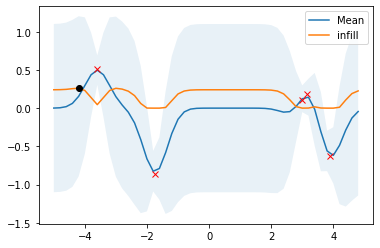

In [519]:
# same as previously (but stripped of comment), we "fit" a GP with the current data
gpr.fit(X_train, Y_train)
mu_s, cov_s = gpr.predict(X, return_cov=True)
l = gpr.kernel_.k2.get_params()['length_scale']
sigma_f = np.sqrt(gpr.kernel_.k1.get_params()['constant_value'])
print("The MAP length scale is {0:.3f} and sigma_f is {1:.3f}".format(l,sigma_f))
# Plot the results
thePlot = plot_gp(mu_s, cov_s, X, X_train=X_train, Y_train=Y_train)
y_pred, y_std, y_best_so_far = mu_s.ravel(), np.sqrt(np.diag(cov_s)), max(Y_train)

# Plot the infill criterion, everywhere
infill = infill_function(y_pred,y_std,y_best_so_far)
thePlot.plot(X,infill,label="infill")
iHope = np.argmax(infill)  # index of what one hopes is a good spot to look at.
thePlot.plot(X[iHope],max(infill),'ok')
thePlot.legend()

# Add a new sample to the data set
X_train = np.append(X_train,np.atleast_2d(X[iHope])).reshape(-1,1)
Y_train = actual_surface(X_train,noise)